In [1]:
# initiation 12/13/2023

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
from matplotlib import gridspec
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# os.getcwd() 
# # change the working directory to the folder where the data is stored

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']

# set the style of the plots
az.style.use("arviz-white")
# set the text font to be Arial
plt.rcParams['font.sans-serif'] = "Arial"


# 1 Data Loading and Preprocessing

Download data from Github.

Format: Columns: **"#_Qx_xxxxx#**
- *Q1_First Click*: timestamp for first click
- *Q1_Last Click*: timestamp for last click
- *Q1_Page Submit*: timestamp for submitting this page
- *Q1_Click Count*: total click times for thhis page
- *Q2*: Response Choice (1: Correct, 2: Incorrect)
- *Q3_1*: Confidence Rating (from 50 to 100)

In [2]:
url = 'https://raw.githubusercontent.com/AbelZheng/NeuroEcon/main/SCM_Data_no_info.csv'
all_data = pd.read_csv(url)
all_data = all_data.drop(['Unnamed: 0'], axis=1)
all_data.head()

,1_Q1_First Click,1_Q1_Last Click,1_Q1_Page Submit,1_Q1_Click Count,1_Q2,1_Q3_1,2_Q1_First Click,2_Q1_Last Click,2_Q1_Page Submit,2_Q1_Click Count,...,82_Q1_Page Submit,82_Q1_Click Count,82_Q2,82_Q3_1,83_Q1_First Click,83_Q1_Last Click,83_Q1_Page Submit,83_Q1_Click Count,83_Q2,83_Q3_1
0,1.104,2.126,2.442,2,1,100,2.541,3.277,3.664,2,...,8.388,2,2,73,1.396,4.119,4.372,4,1,100
1,3.196,3.933,5.193,2,1,51,2.619,3.898,4.198,3,...,5.160,2,2,87,6.175,6.957,7.535,2,1,83
2,1.365,2.687,3.438,2,1,100,3.313,5.564,6.474,3,...,6.618,2,1,74,3.924,5.003,6.323,2,1,100
3,1.459,2.647,3.641,3,1,100,2.967,4.101,4.700,3,...,5.248,5,2,97,2.766,3.850,4.717,2,1,100
4,2.173,4.885,5.344,3,1,52,2.818,4.383,8.206,2,...,7.052,2,2,55,7.033,43.480,54.424,4,1,100


In [3]:
# Arrange the Columns:
total_question_number = 83
Qidx = np.arange(1, total_question_number+1)
subfixes  = ['Q1_FistClick', 'Q1_LastClick', 'Q1_PageSubmit', 'Q1_ClickCount', 'Q2','Q3_1']

# Create a list of column names
# col_names = []
# for i in range(1, total_question_number+1):
#     for j in range(1, 7):
#         col_names.append('{}_{}'.format(i, subfixes[j-1]))

# Extract Responses For All Questions
Response_Acc_All = pd.DataFrame()
Response_Confi_All = pd.DataFrame()

Response_Acc_Mean = []
Response_Acc_SD = []
Response_Confi_Mean = []
Response_Confi_SD = []
for i in range(1, total_question_number+1):
    Response = all_data['{}_{}'.format(i, 'Q2')]
    Response.replace(2, 0, inplace=True)
    Response_Acc_All = pd.concat([Response_Acc_All, Response], axis=1)
    Response_Confi = all_data['{}_{}'.format(i, 'Q3_1')]
    Response_Confi_All = pd.concat([Response_Confi_All, Response_Confi], axis=1)
    
    Response_Acc_Mean.append(Response.mean())
    Response_Acc_SD.append(Response.std())
    Response_Confi_Mean.append(Response_Confi.mean())
    Response_Confi_SD.append(Response_Confi.std())
    
# Rename the columns to 'Q{}' format
Response_Acc_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]
Response_Confi_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]

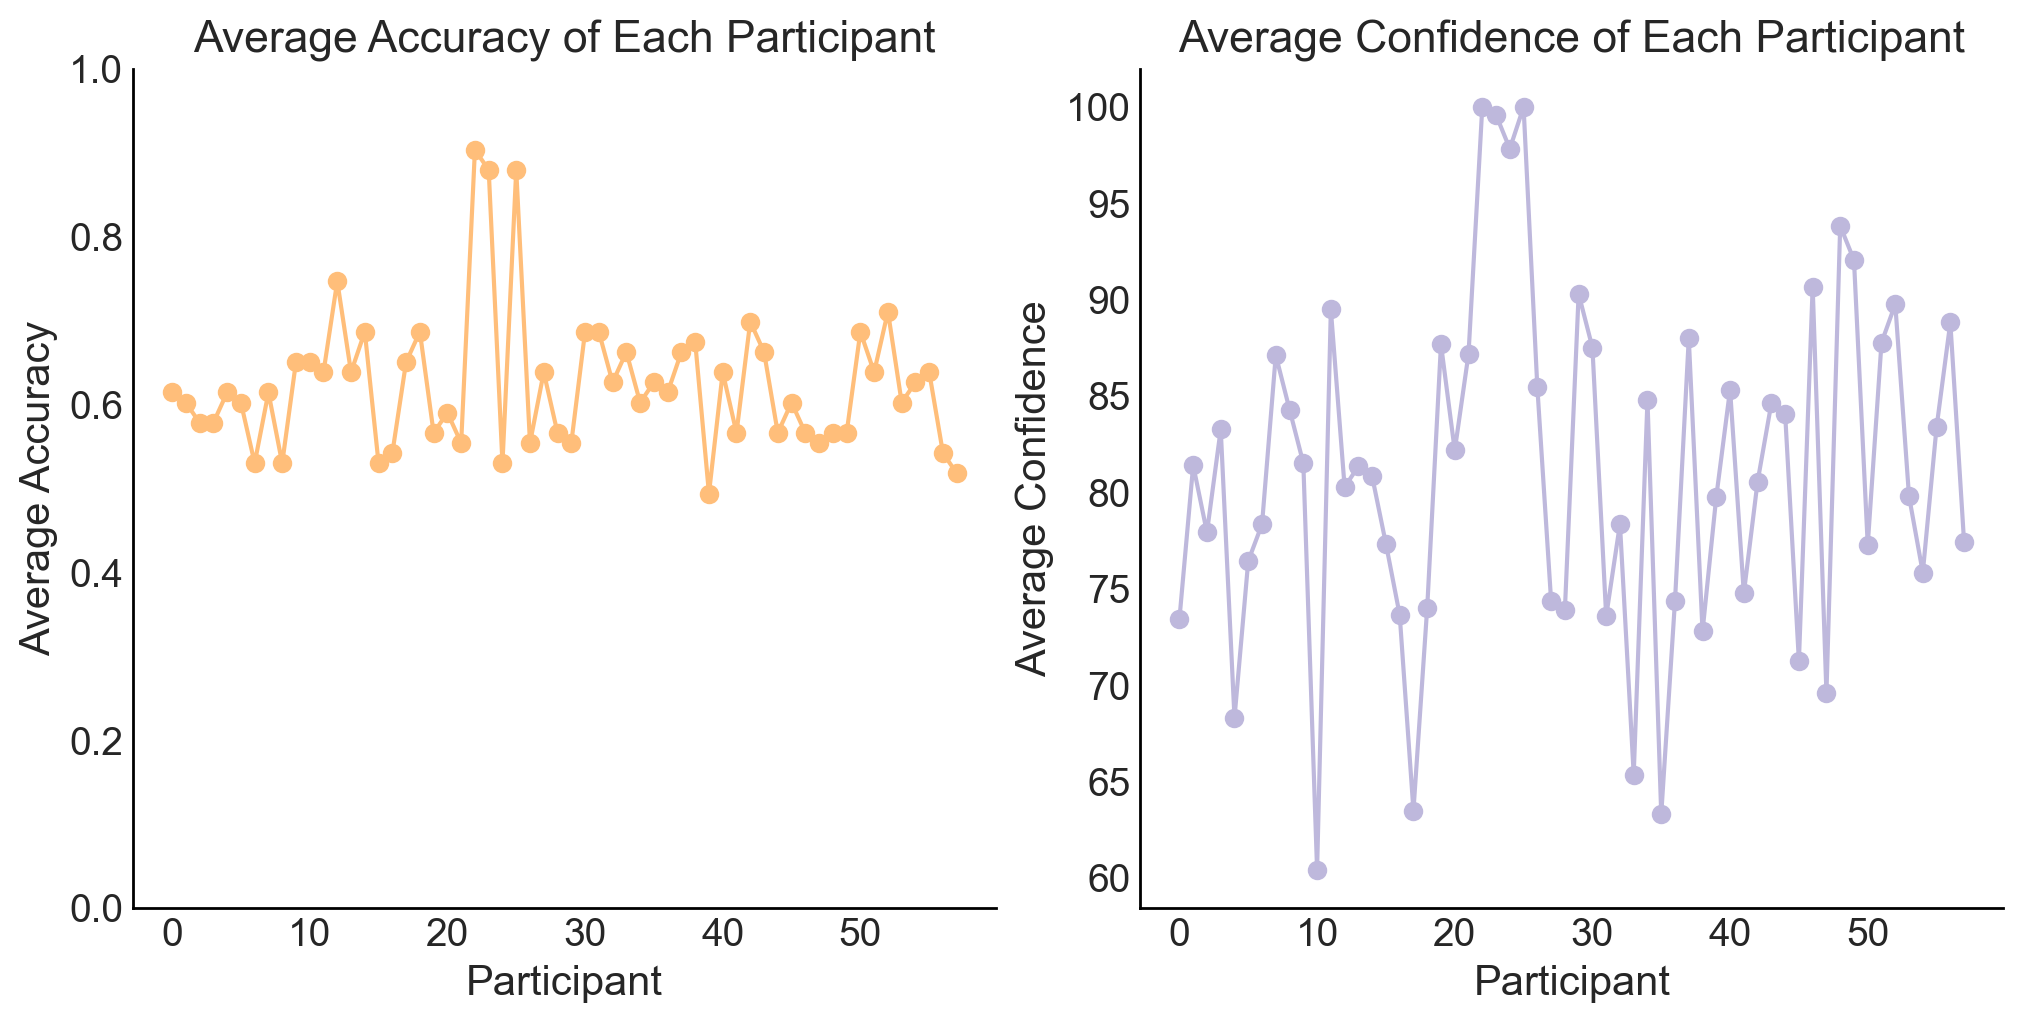

In [4]:
# Draw each participant's average accuracy and confidence

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(Response_Acc_All.mean(axis=1), 'o-', color=ye)
ax[0].set_xlabel('Participant')
ax[0].set_ylabel('Average Accuracy')
ax[0].set_ylim([0, 1])
ax[0].set_title('Average Accuracy of Each Participant')
ax[1].plot(Response_Confi_All.mean(axis=1), 'o-', color=pu)
ax[1].set_xlabel('Participant')
ax[1].set_ylabel('Average Confidence')
ax[1].set_title('Average Confidence of Each Participant')
plt.show()

## 1.1 Screening: Outliers in Accuracy and Confidence

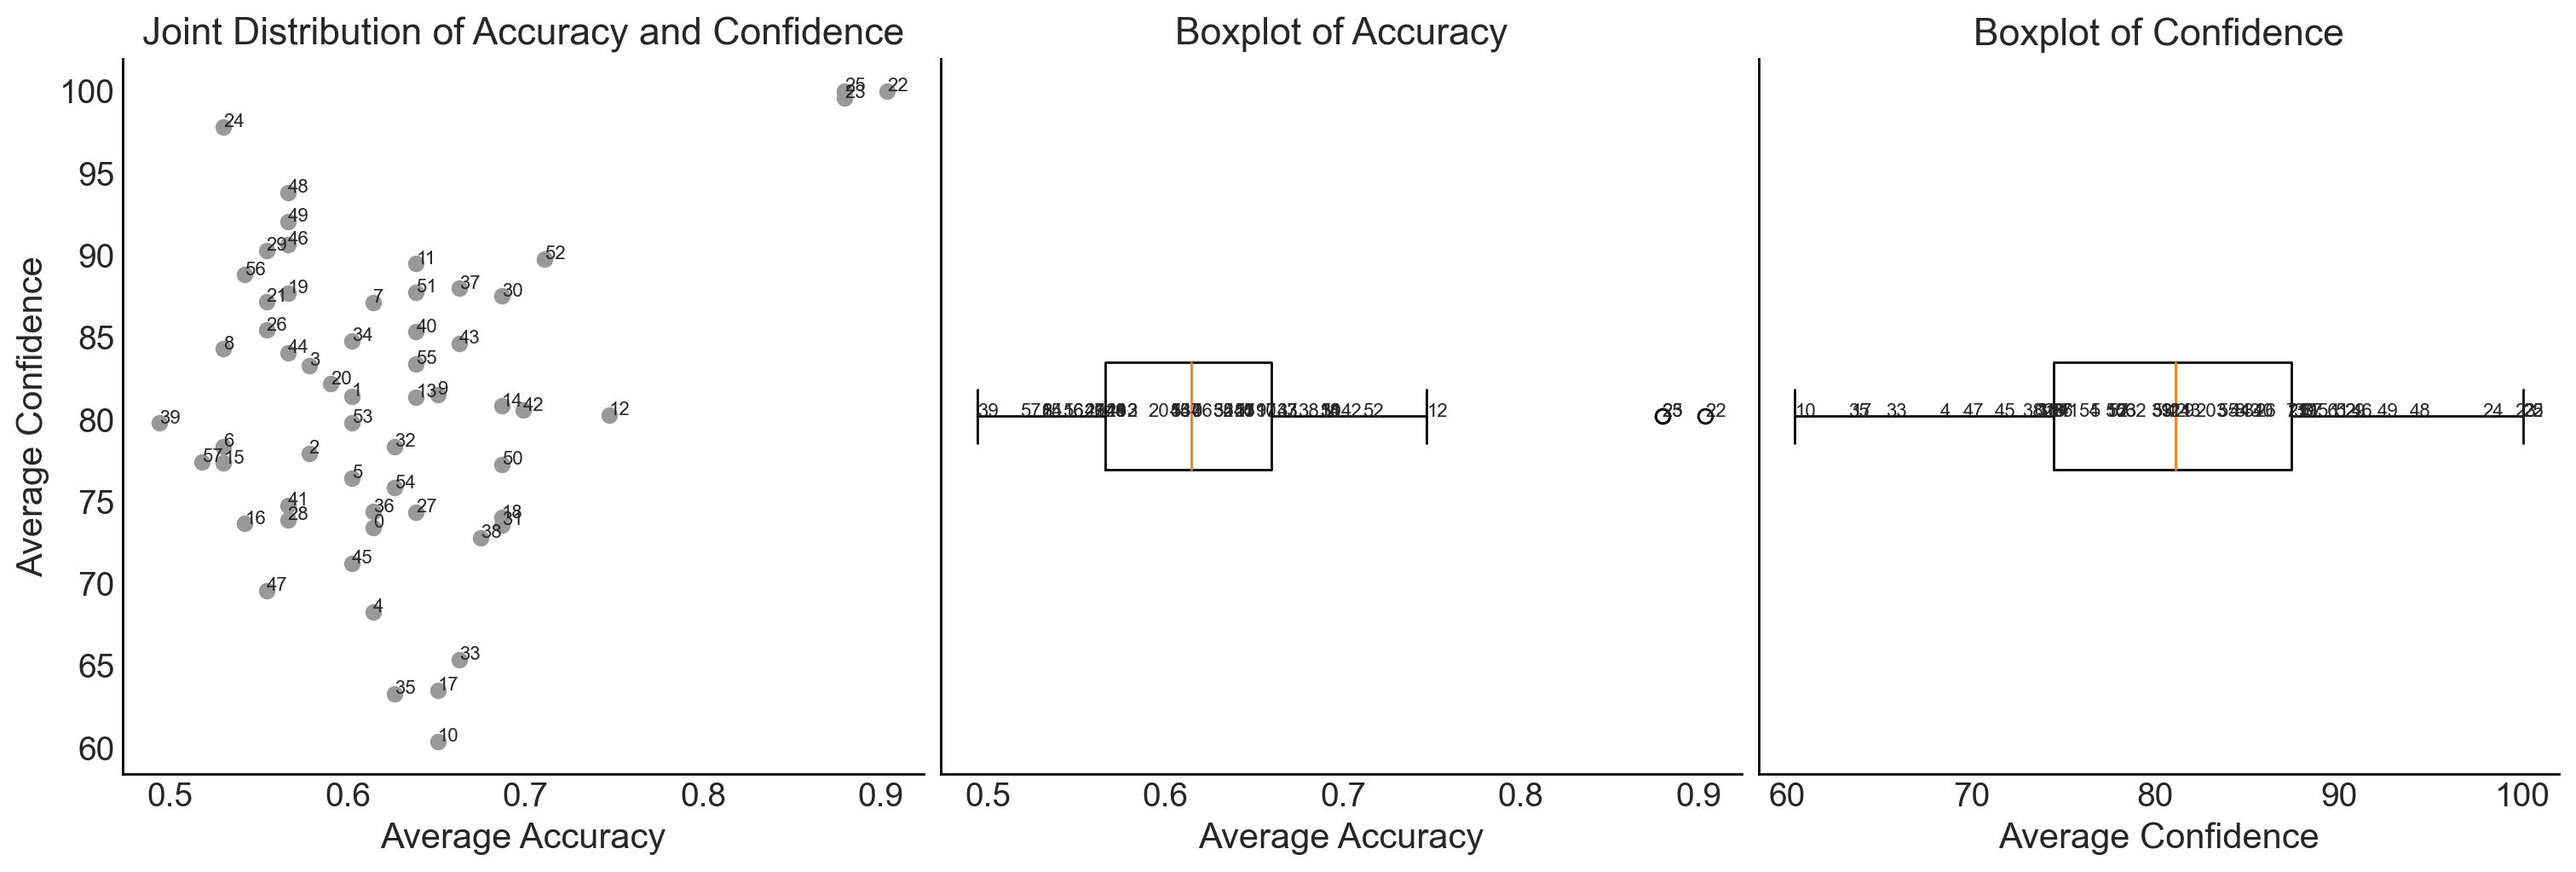

In [5]:
# If confidence and accuracy(ability) are correlated
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Joint Distribution of Accuracy and Confidence')
plt.plot(Response_Acc_All.mean(axis=1), Response_Confi_All.mean(axis=1), 'o', color=ak)
# Add participant ID labels
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Acc_All.mean(axis=1)[i], Response_Confi_All.mean(axis=1)[i], participant_id, fontsize=8)
plt.xlabel('Average Accuracy')
plt.ylabel('Average Confidence')

# boxplot and label for accuracy
plt.subplot(1, 3, 2)
plt.title('Boxplot of Accuracy')
plt.boxplot(Response_Acc_All.mean(axis=1), vert=False)
plt.xlabel('Average Accuracy')
plt.yticks([])
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Acc_All.mean(axis=1)[i], 1, participant_id, fontsize=8)

# boxplot and label for confidence
plt.subplot(1, 3, 3)
plt.title('Boxplot of Confidence')
plt.boxplot(Response_Confi_All.mean(axis=1), vert=False)
plt.xlabel('Average Confidence')
plt.yticks([])
for i, participant_id in enumerate(Response_Acc_All.index):
    plt.text(Response_Confi_All.mean(axis=1)[i], 1, participant_id, fontsize=8)

plt.show()


In [6]:
All_Subj_Confi =  Response_Confi_All.mean(axis=1)
find_idx = np.where(All_Subj_Confi == 100)[0]
# subj 23 also seems to be an outlier
find_idx = np.append(find_idx, 23)
print(find_idx)

[22 25 23]


Actually, the result is negatively correlated.

2 subjects seem to report with all 100 confindence, which is not possible, so we exclude them. (which is subject 22 and 25)

And another one (subj 23) also seem to have extreme high confidence as well as accuracy, so we exclude him as well.

In [7]:
all_data.drop(find_idx, inplace=True)

# Arrange the Columns:
total_question_number = 83
Qidx = np.arange(1, total_question_number+1)
subfixes  = ['Q1_FistClick', 'Q1_LastClick', 'Q1_PageSubmit', 'Q1_ClickCount', 'Q2','Q3_1']

# Create a list of column names
# col_names = []
# for i in range(1, total_question_number+1):
#     for j in range(1, 7):
#         col_names.append('{}_{}'.format(i, subfixes[j-1]))

# Extract Responses For All Questions
Response_Acc_All = pd.DataFrame()
Response_Confi_All = pd.DataFrame()

Response_Acc_Mean = []
Response_Acc_SD = []
Response_Confi_Mean = []
Response_Confi_SD = []
for i in range(1, total_question_number+1):
    Response = all_data['{}_{}'.format(i, 'Q2')]
    Response.replace(2, 0, inplace=True)
    Response_Acc_All = pd.concat([Response_Acc_All, Response], axis=1)
    Response_Confi = all_data['{}_{}'.format(i, 'Q3_1')]
    Response_Confi_All = pd.concat([Response_Confi_All, Response_Confi], axis=1)
    
    Response_Acc_Mean.append(Response.mean())
    Response_Acc_SD.append(Response.std())
    Response_Confi_Mean.append(Response_Confi.mean())
    Response_Confi_SD.append(Response_Confi.std())
    
# Rename the columns to 'Q{}' format
Response_Acc_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]
Response_Confi_All.columns = ['Q{}'.format(i) for i in range(1, total_question_number+1)]

# 2 Processing on Absolute Value

## 2.1 Finding the CC and CW Questions

In this section, we do t-test to find trials that have mean accuracy significantly higher and lower than chance level. 

We then use the trials with significantly higher accuracy as CC questions and the trials with significantly lower accuracy as CW questions.

First, we set the significance level a little bit looser, at 0.1, to find more trials that are significantly different from chance level.


In [9]:
# Single Sample t-test
from scipy import stats
ttest_tvalues = []
ttest_pvalues = []
alpha = 0.05
types = {'CC', 'CW', 'Chance'}
Q_types = []

for i in range(1, total_question_number+1):
    ttest_tvalues.append(stats.ttest_1samp(Response_Acc_All['Q{}'.format(i)], 0.5)[0])
    ttest_pvalues.append(stats.ttest_1samp(Response_Acc_All['Q{}'.format(i)], 0.5)[1])
    if ttest_pvalues[i-1] < alpha:
        if ttest_tvalues[i-1] > 0:
            Q_types.append('CC')
        else:
            Q_types.append('CW')
    else:
        Q_types.append('Chance')

Mean_Accuracy_Test = pd.DataFrame({'Question': Qidx, 'Mean_Accuracy': Response_Acc_Mean, 'SD_Accuracy': Response_Acc_SD, 't_value': ttest_tvalues, 'p_value': ttest_pvalues, 'Type': Q_types})
Mean_Accuracy_Test.head()
Mean_Accuracy_Test.to_csv('Mean_Accuracy_Test.csv')

So, now we know which trials are CC and CW questions. We can now use the CC and CW questions to train a classifier to predict the CC and CW questions.


In [65]:
print('The number of CC questions is: {}'.format(Q_types.count('CC')))
CC_idx = np.where(np.array(Q_types) == 'CC')[0] + 1
print('Index of CC questions: {}'.format(CC_idx))
print()
CW_idx = np.where(np.array(Q_types) == 'CW')[0] + 1
print('The number of CW questions is: {}'.format(Q_types.count('CW')))
print('Index of CW questions: {}'.format(CW_idx))

The number of CC questions is: 41
Index of CC questions: [ 1  3  9 11 12 13 14 15 20 23 25 26 31 33 40 42 43 44 45 46 48 49 50 51
 52 54 56 57 58 60 61 62 63 67 69 71 75 77 79 81 83]

The number of CW questions is: 17
Index of CW questions: [ 2  4  5 19 22 27 28 35 36 37 38 39 47 53 55 68 76]


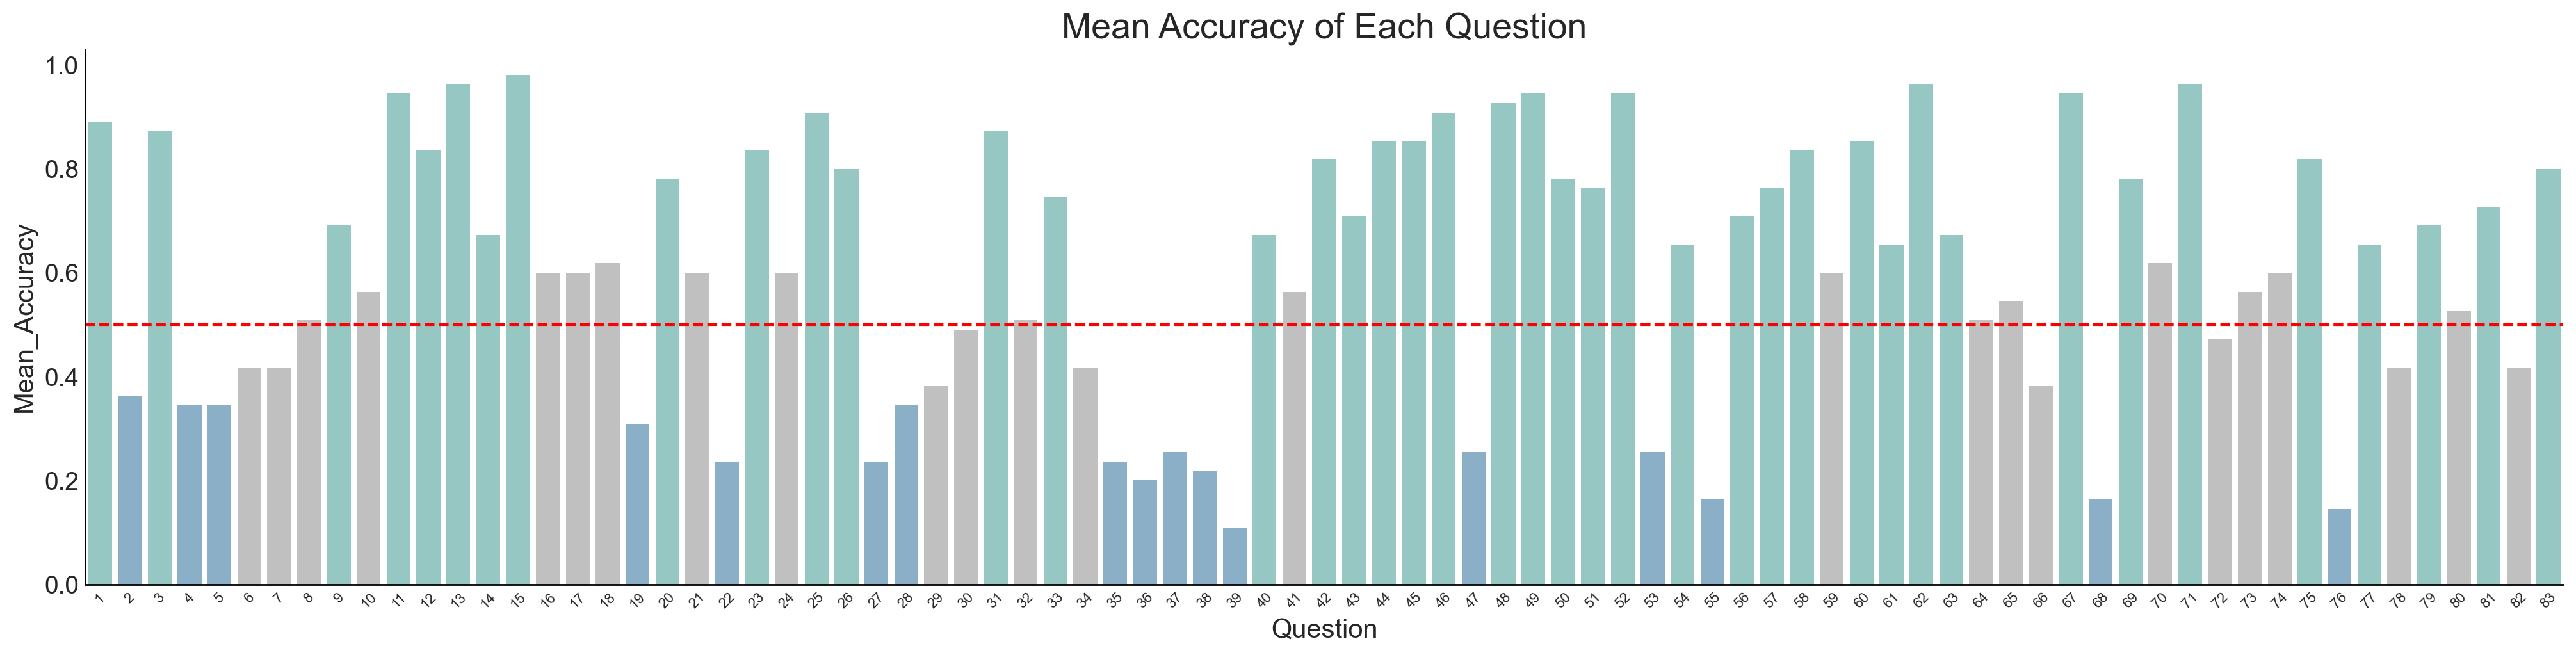

In [66]:
# visualize the data
# all the CC questions are colored gr, CW colored bl, and Chance colored sil

color_pallette = []
for i in range(1, total_question_number+1):
    if Mean_Accuracy_Test['Type'][i-1] == 'CC':
        color_pallette.append(gr)
    elif Mean_Accuracy_Test['Type'][i-1] == 'CW':
        color_pallette.append(bl)
    else:
        color_pallette.append(sil)

plt.figure(figsize=(20, 5))
sns.barplot(x='Question', y='Mean_Accuracy', data=Mean_Accuracy_Test, palette=color_pallette)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation = 45, fontsize=8)
plt.title('Mean Accuracy of Each Question', fontsize=20)
plt.show()

## 2.2 See the Correlation between the Consensus and Confidence

Based on Self Consistency Model, **individual's confidence should be correlated with the population consensus**, which is a reflection of the common implict knowledge of the population.

In this section, we do the correlation analysis between the confidence and the consensus. For CC questions, we expect to see a positive correlation between the confidence and the consensus. For CW questions, the consensus is actually th wrong answer, so we expect to see a negative correlation between the confidence and the mean accuracy.

Or, we could flip the sign of the consensus for CW questions, and then we expect to see a positive correlation between the confidence and the consensus.


In [67]:
Consensus_Confidence = pd.DataFrame({'Question': Qidx, 'Mean_Accuracy': Response_Acc_Mean, 'SD_Accuracy': Response_Acc_SD, 'Mean_Confidence': Response_Confi_Mean, 'SD_Confidence': Response_Confi_SD, 'Type': Q_types})
CC_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CC']
CC_Con_Con['Consensus'] = CC_Con_Con['Mean_Accuracy']
CW_Con_Con = Consensus_Confidence[Consensus_Confidence['Type'] == 'CW']
CW_Con_Con['Consensus'] = 1 - CW_Con_Con['Mean_Accuracy']
Avg_Con_Con = pd.concat([CC_Con_Con, CW_Con_Con], axis=0)

CC_Corr = stats.pearsonr(CC_Con_Con['Consensus'], CC_Con_Con['Mean_Confidence'])
CW_Corr = stats.pearsonr(CW_Con_Con['Consensus'], CW_Con_Con['Mean_Confidence'])
Avg_Con_Con_Corr = stats.pearsonr(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'])

print('The correlation between consensus and confidence for CC questions is: {}'.format(CC_Corr))
print('The correlation between consensus and confidence for CW questions is: {}'.format(CW_Corr))
print('The correlation between consensus and confidence for all questions is: {}'.format(Avg_Con_Con_Corr))

print()

The correlation between consensus and confidence for CC questions is: PearsonRResult(statistic=0.46809845598324157, pvalue=0.002026352306273453)
The correlation between consensus and confidence for CW questions is: PearsonRResult(statistic=0.06230035702122838, pvalue=0.8122417019440524)
The correlation between consensus and confidence for all questions is: PearsonRResult(statistic=0.3957029419898857, pvalue=0.002108324854330874)



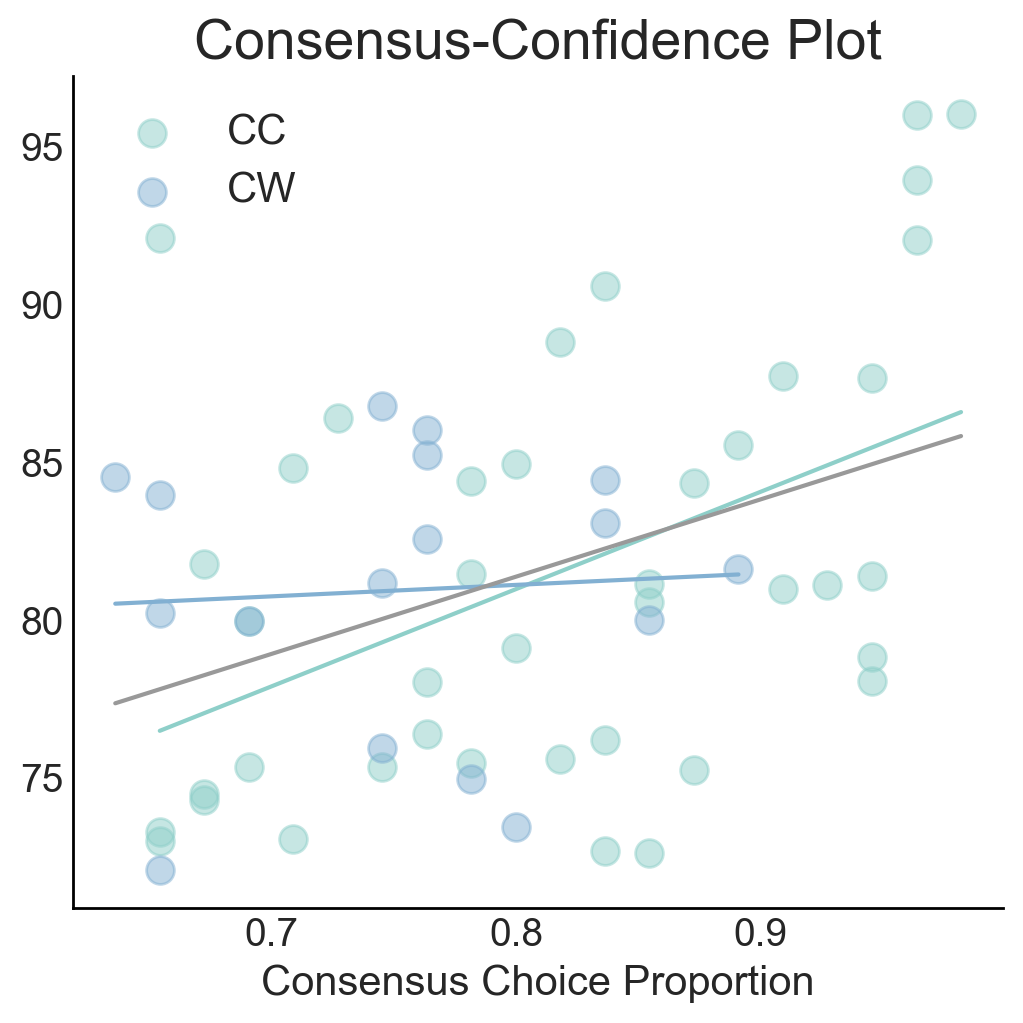

In [68]:
# visualize the data

# Flip the accuracy in CW (1-x), and draw consensus-confidence plot
plt.figure(figsize=(5, 5))
plt.scatter(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], c=gr, label='CC', alpha=0.5, s=100)
plt.scatter(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], c=bl, label='CW', alpha=0.5, s=100)
plt.legend(fontsize=15)
# draw the line of best fit
plt.plot(np.unique(CC_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(CC_Con_Con['Mean_Accuracy'], CC_Con_Con['Mean_Confidence'], 1))(np.unique(CC_Con_Con['Mean_Accuracy'])), c=gr)
plt.plot(np.unique(1-CW_Con_Con['Mean_Accuracy']), np.poly1d(np.polyfit(1-CW_Con_Con['Mean_Accuracy'], CW_Con_Con['Mean_Confidence'], 1))(np.unique(1-CW_Con_Con['Mean_Accuracy'])), c=bl)
plt.plot(np.unique(Avg_Con_Con['Consensus']), np.poly1d(np.polyfit(Avg_Con_Con['Consensus'], Avg_Con_Con['Mean_Confidence'], 1))(np.unique(Avg_Con_Con['Consensus'])), c=ak)
plt.xlabel('Consensus Choice Proportion', fontsize=15)
plt.title('Consensus-Confidence Plot', fontsize=20)
plt.show()



So, it appears that for CC questions, SCM hypothesis is supported. For CW questions, the SCM hypothesis is not supported.


# 3 Maximum Confidence Slating Model Replication

In this section, we test the MCS model for joint decision.

It predicts:
- The joint decision is made by the subject who is more confident in their choice;
- For CC questions, the joint decision accracy is higher than the individual decision accuracy;
- For CW questions, the joint decision accracy is lower than the individual decision accuracy.

We test this on the whole **Q_list, CC and CW** trials separately.

In [88]:
def Dummy_HC(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    This function is used to simulate the joint decision based on MCS model for two subjects.
    AKA, generate the dummy subject's choice and confidence based on the choice with higher confidence.
    Input:
    subj_#_choice: the choice of subject #, 0 for wrong, 1 for right (for all questions)
    subj_#_confi: the confidence of subject #, range from 50 to 100
    
    Output:
    joint_choice: the joint decision of the two subjects, 0 for wrong, 1 for right (for all questions)
    joint_confi: the confidence of the joint decision, range from 50 to 100
    performance: if the joint decision accuarcy is lower than both, 0; if the joint decision accuarcy is higher than both, 1; if the joint decision accuarcy is higher than one but lower than the other, 0.5
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        joint_confi.append(max(subj_1_confi[i], subj_2_confi[i]))
        if subj_1_choice[i] == subj_2_choice[i]:
            joint_choice.append(subj_1_choice[i])
        else:
            if subj_1_confi[i] > subj_2_confi[i]:
                joint_choice.append(subj_1_choice[i])
            elif subj_1_confi[i] < subj_2_confi[i]:
                joint_choice.append(subj_2_choice[i])
            else:
                joint_choice.append(np.random.choice([subj_1_choice[i], subj_2_choice[i]]))
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance
                
def Dummy_LC(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    Conditional control, generate the dummy subject's choice and confidence based on the choice with lower confidence.
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        joint_confi.append(min(subj_1_confi[i], subj_2_confi[i]))
        if subj_1_choice[i] == subj_2_choice[i]:
            joint_choice.append(subj_1_choice[i])
        else:
            if subj_1_confi[i] < subj_2_confi[i]:
                joint_choice.append(subj_1_choice[i])
            elif subj_1_confi[i] > subj_2_confi[i]:
                joint_choice.append(subj_2_choice[i])
            else:
                joint_choice.append(np.random.choice([subj_1_choice[i], subj_2_choice[i]]))
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance

def Dummy_random(subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi):
    '''
    Conditional control2, generate the dummy subject's choice and confidence based on random choice from the two alternatives.
    '''
    joint_choice = []
    joint_confi = []
    
    for i in range(len(subj_1_choice)):
        random_idx = np.random.choice([0, 1])
        joint_confi.append([subj_1_confi[i], subj_2_confi[i]][random_idx])
        joint_choice.append([subj_1_choice[i], subj_2_choice[i]][random_idx])
    
    acc = np.mean(joint_choice)
    if acc < np.min([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 0 
    elif acc > np.max([np.mean(subj_1_choice), np.mean(subj_2_choice)]):
        performance = 1
    else:
        performance = 0.5
    
    return joint_choice, joint_confi, performance
    

In [91]:
import numpy as np

def calculate_performance_matrix(all_subj_acc, all_subj_confi, dummy_function):
    subjnum = len(all_subj_acc)
    performance_matrix = np.zeros((subjnum, subjnum))
    avg_accuracy_matrix = np.zeros((subjnum, subjnum))

    for i in range(subjnum):
        for j in range(subjnum):
            if i != j:
                subj_1_choice = all_subj_acc.iloc[i, :]
                subj_1_confi = all_subj_confi.iloc[i, :]
                subj_2_choice = all_subj_acc.iloc[j, :]
                subj_2_confi = all_subj_confi.iloc[j, :]

                joint_choice, joint_confi, performance = dummy_function(
                    subj_1_choice, subj_1_confi, subj_2_choice, subj_2_confi
                )

                performance_matrix[i, j] = performance
                avg_accuracy_matrix[i, j] = np.mean(joint_choice)

    return performance_matrix, avg_accuracy_matrix


CC_All_Subj = Response_Acc_All.iloc[:, CC_idx-1]
CC_Confi_All_Subj = Response_Confi_All.iloc[:, CC_idx-1]
CW_All_Subj = Response_Acc_All.iloc[:, CW_idx-1]
CW_Confi_All_Subj = Response_Confi_All.iloc[:, CW_idx-1]


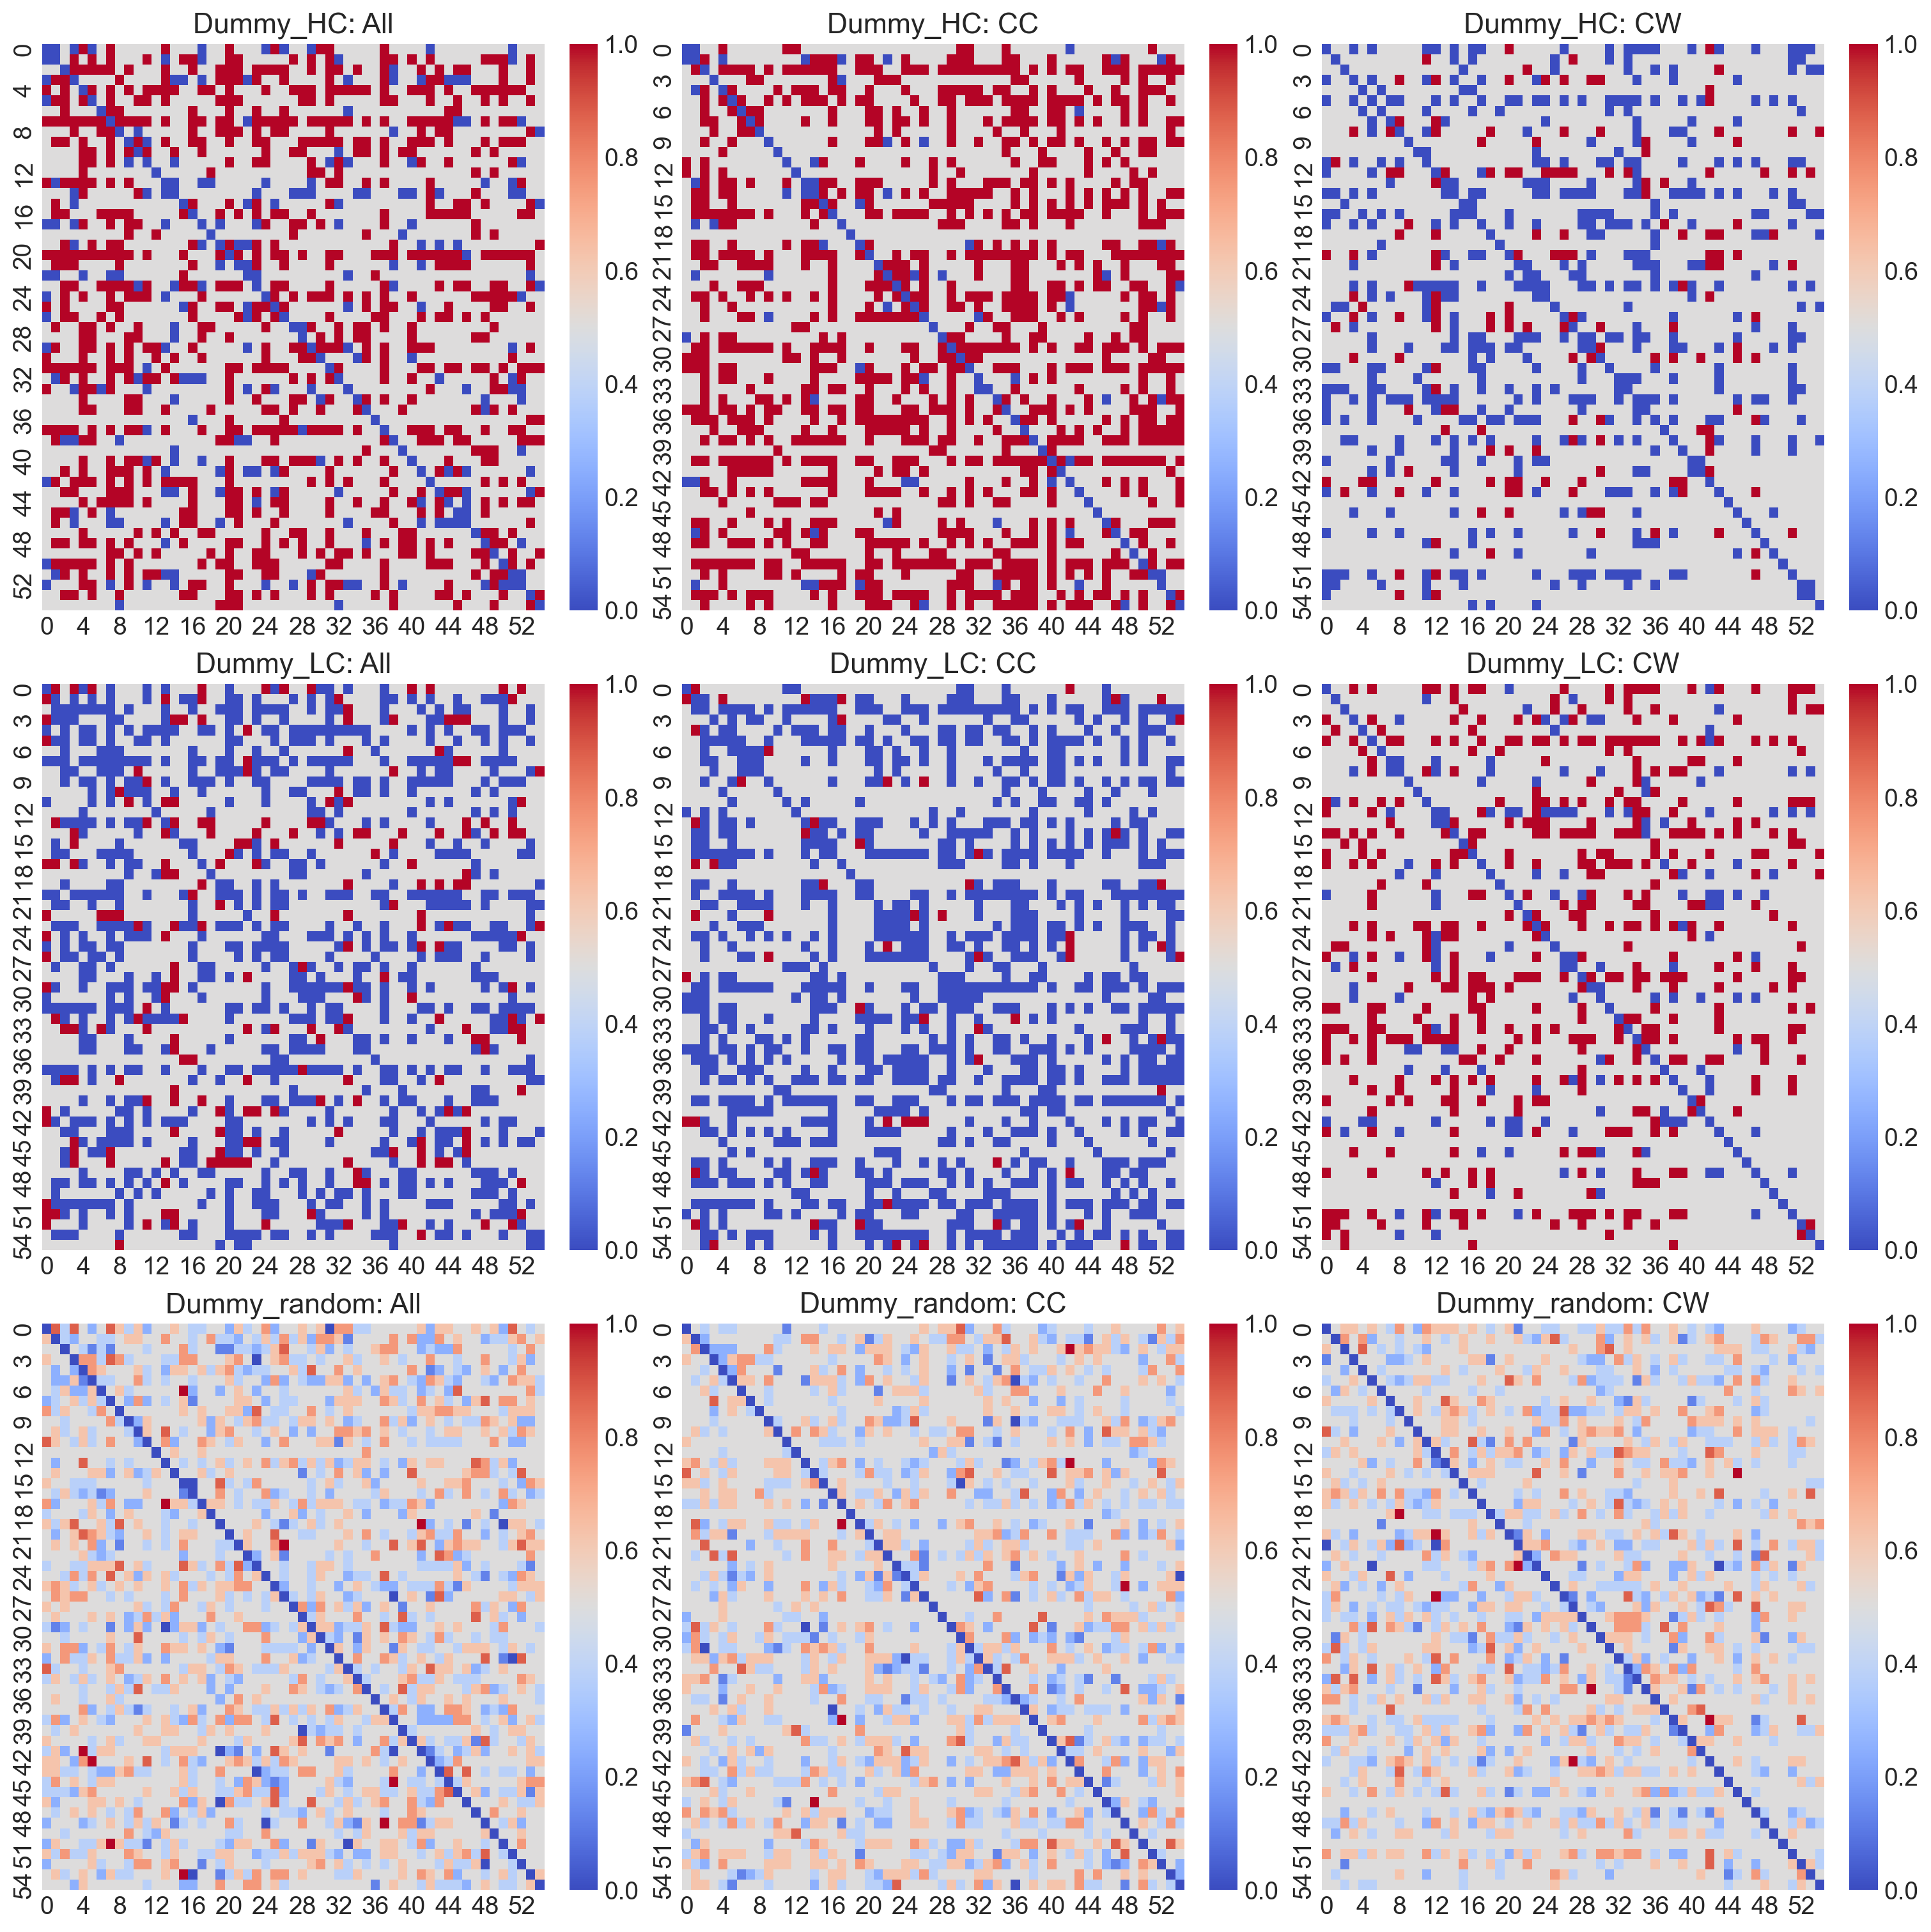

In [92]:
# calculate_performance_matrix for 3 methods, then visualize the results

funcs = [Dummy_HC, Dummy_LC, Dummy_random]
Q_types = ['All', 'CC', 'CW']
Q_data_choice = [Response_Acc_All, CC_All_Subj, CW_All_Subj]
Q_data_confi = [Response_Confi_All, CC_Confi_All_Subj, CW_Confi_All_Subj]
performance_matrix_dict = {}
avg_accuracy_matrix_dict = {}

rep_times = 4

for i in range(len(funcs)):
    for j in range(len(Q_types)):
        if i != 2:
            performance_matrix, avg_accuracy_matrix = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
        else:
            # for Dummy_random, we need to repeat the calculation for rep_times and take average
            performance_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            avg_accuracy_matrix = np.zeros((len(Q_data_choice[j]), len(Q_data_choice[j])))
            for k in range(rep_times):
                performance_matrix_temp, avg_accuracy_matrix_temp = calculate_performance_matrix(Q_data_choice[j], Q_data_confi[j], funcs[i])
                performance_matrix += performance_matrix_temp
                avg_accuracy_matrix += avg_accuracy_matrix_temp
            performance_matrix /= rep_times
            avg_accuracy_matrix /= rep_times
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        performance_matrix_dict[temp_key] = performance_matrix
        avg_accuracy_matrix_dict[temp_key] = avg_accuracy_matrix
        

# visualize the results, plot row for 3 func, column for 3 types
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for i in range(len(funcs)):
    for j in range(len(Q_types)):
        temp_key = '{}_{}'.format(funcs[i].__name__, Q_types[j])
        sns.heatmap(performance_matrix_dict[temp_key], ax=ax[i, j], cmap='coolwarm', vmin=0, vmax=1)
        ax[i, j].set_title('{}: {}'.format(funcs[i].__name__, Q_types[j]))
plt.show()


In [34]:
# 2-sample test between all-subjects and MCS
from scipy import stats
print('All Question Accuracy: {} +/- {}'.format(np.mean(Response_Acc_All.mean(axis=1)), np.std(Response_Acc_All.mean(axis=1))))
print('MCS(Dummy-HC) All Question Accuracy{} +/- {}'.format(np.mean(avg_accuracy_matrix), np.std(avg_accuracy_matrix)))
results = stats.ttest_ind(avg_accuracy_matrix.flatten(), Response_Acc_All.mean(axis=1))
print('t-test on all questions between MCS and all subjects: {}'.format(results))
print()
print('CC Question Accuracy: {} +/- {}'.format(np.mean(CC_All_Subj.mean(axis=1)), np.std(CC_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) CC Question Accuracy{} +/- {}'.format(np.mean(CC_avg_accuracy_matrix), np.std(CC_avg_accuracy_matrix)))
results = stats.ttest_ind(CC_avg_accuracy_matrix.flatten(), CC_All_Subj.mean(axis=1))
print('t-test on CC between MCS and all subjects: {}'.format(results))
print()
print('CW Question Accuracy: {} +/- {}'.format(np.mean(CW_All_Subj.mean(axis=1)), np.std(CW_All_Subj.mean(axis=1))))
print('MCS(Dummy-HC) CW Question Accuracy{} +/- {}'.format(np.mean(CW_avg_accuracy_matrix), np.std(CW_avg_accuracy_matrix)))
results = stats.ttest_ind(CW_avg_accuracy_matrix.flatten(), CW_All_Subj.mean(axis=1))
print('t-test on CW between MCS and all subjects: {}'.format(results))
      

All Question Accuracy: 0.6096385542168674 +/- 0.056352018193431844
MCS(Dummy-HC) All Question Accuracy0.611626008164891 +/- 0.09886531405645048
t-test on all questions between MCS and all subjects: Ttest_indResult(statistic=0.1485985251215571, pvalue=0.8818801710350925)

CC Question Accuracy: 0.8164079822616407 +/- 0.07597786729955504
MCS(Dummy-HC) CC Question Accuracy0.8344607941947187 +/- 0.13018742519025325
t-test on CC between MCS and all subjects: Ttest_indResult(statistic=1.0248859833708643, pvalue=0.3054975265713044)

CW Question Accuracy: 0.24598930481283424 +/- 0.1224120122166802
MCS(Dummy-HC) CW Question Accuracy0.2149927078269324 +/- 0.1178883795207875
t-test on CW between MCS and all subjects: Ttest_indResult(statistic=-1.9304900173834418, pvalue=0.053637905599321245)
